<a href="https://colab.research.google.com/github/vubanc/MovieGenreIdentifier_NLP/blob/main/MovieGenreIdentifier_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Identifier**

This is an NLP (Natural Language Processing) project. The objective of this project is to build a model that predicts the genre of a movie by taking the movie's description as input. The dataset for this project was produced by merging three different movies datasets collected from Kaggle. Every movie in the dataset has a title, a description and one or more genres. In this notebook, a LSTM (long-short-term memory) model was trained and tested on the dataset to predict the genres of the movies.

**Overview of the Cleaned Dataset**
- Total Movies: 4000
- Total Genres: 5
- Oldest Movie in the dataset is The Cabinet of Dr. Caligari from 1920
- Latest Movie in the dataset is The Gray Man from 2022

**Visual Representation of the Model**
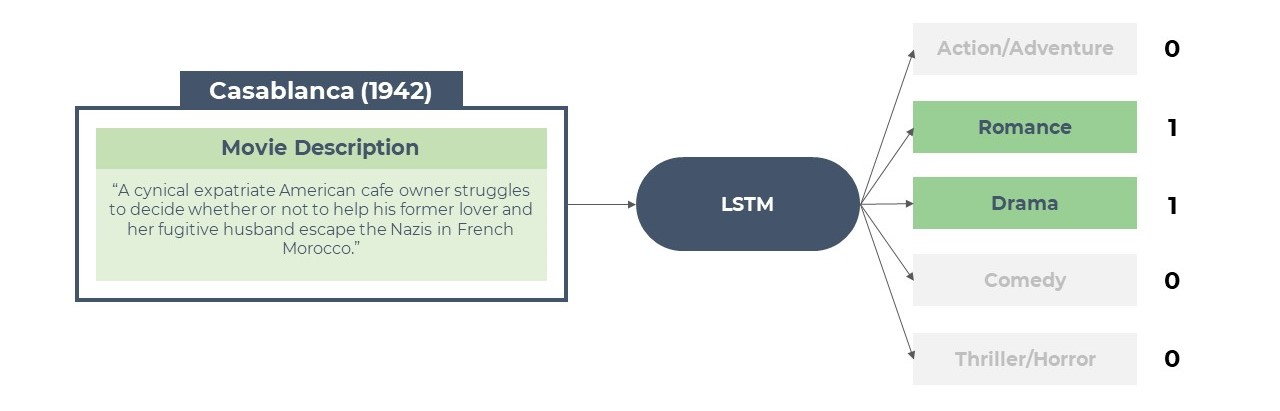

### **Importing Libraries and Datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy

import random

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

!pip install ray
from ray import tune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 8.8 MB/s eta 0:00:00


In [5]:
df_input = pd.read_csv("/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP/LSTM Input.csv", index_col=0)

In [6]:
features = np.array(df_input.iloc[:,0:-5])
vocabulary_length = np.max(features)+1

action_labels = np.array(df_input["action_labels"])
romance_labels = np.array(df_input["romance_labels"])
drama_labels = np.array(df_input["drama_labels"])
comedy_labels = np.array(df_input["comedy_labels"])
thriller_labels = np.array(df_input["thriller_labels"])

all_labels = np.array(df_input.iloc[:,-5:])

In [7]:
#Assessing imbalance in the dataset
print(f"Percentage of action/adventure movies: {np.mean(all_labels[:,0])}")
print(f"Percentage of romance movies: {np.mean(all_labels[:,1])}")
print(f"Percentage of drama movies: {np.mean(all_labels[:,2])}")
print(f"Percentage of comedy movies: {np.mean(all_labels[:,3])}")
print(f"Percentage of thriller/horror movies: {np.mean(all_labels[:,4])}")

Percentage of action/adventure movies: 0.3346662565364503
Percentage of romance movies: 0.23223623500461396
Percentage of drama movies: 0.5167640725930482
Percentage of comedy movies: 0.4666256536450323
Percentage of thriller/horror movies: 0.27683789603199016


### **Helper Functions**

In [8]:
#Splitting training, validation, and testing data for action labels only
def data_splitter(features, labels):
  split_frac = 0.8
  train_x = features[0:int(split_frac*len(features))]
  train_y = labels[0:int(split_frac*len(features))]
  remaining_x = features[int(split_frac*len(features)):]
  remaining_y = labels[int(split_frac*len(features)):]
  valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
  valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
  test_x = remaining_x[int(len(remaining_x)*0.5):]
  test_y = remaining_y[int(len(remaining_y)*0.5):]

  return train_x, train_y, valid_x, valid_y, test_x, test_y

In [21]:
def data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, batch_size):
  train_data = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
  valid_data = TensorDataset(torch.from_numpy(valid_x).float(), torch.from_numpy(valid_y).float())
  test_data = TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())

  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=True, batch_size=len(test_data))

  return train_loader, valid_loader, test_loader

### **LSTM Class**

In [130]:
class LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, number_of_layers, learning_rate, loss, dropout_prob):
    super(LSTM,self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.number_of_layers = number_of_layers
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, number_of_layers, dropout=dropout_prob, batch_first=True) #Input shape >- (batch_size, sequence_length, number_of_features)
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid() #1/(1+e^-x)
    self.dropout = nn.Dropout(dropout_prob)

    if loss=="CrossEntropyLoss":
      self.loss = nn.CrossEntropyLoss() #Cross Entropy
    if loss=="BCELoss":
      self.loss = nn.CrossEntropyLoss() #Binary Cross Entropy Loss
    elif loss=="HingeEmbeddingLoss":
      self.loss = nn.HingeEmbeddingLoss() #Binary Cross Entropy Loss

    self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data #the "next" function is used to get the next element from the iterator returned by self.parameters()

    #Note that this hidden is the initial hidden state, which is why it is set to zero.
    #Moreover, the dimension is (number_of_layers, batch_size, hidden_size) and not (number_of_layers, seq_length, hidden_size)
    #because this initial hidden state is for the first time sequence not for all time sequences.
    hidden = (weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_(),
               weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_()) #"weight.new()" creates tensor with the same data type as weight but not the same dimensions
    return hidden

  def forward(self, hidden, input): #This forward method produces outputs for an entire batch of inputs
    batch_size = input.size(0)
    input = input.to(torch.int64)

    embedded_input = self.embedding(input) #Converts input from [batch_size, sequence_length] to [batch_size, sequence_length, embedding_size]
    outputs,hn = self.lstm(embedded_input, hidden) #Outputs -> [batch_size, seq_length, hidden_size] hn-> [number_of_layers, batch_size, hidden_size]
    outputs = outputs.contiguous().view(-1,self.hidden_size) #Reshapes to [batch_size*sequence_length, hidden_size]

    outputs = self.dropout(outputs) #Randomly converts some elements to 0 (with prob=0.3) and then multiplies all elements with scaling factor = 1/(1-prob)
    outputs = self.fc(outputs) #Linear transformation on outputs/hidden states from all time steps. Outputs shape [batch_size*seq_length, output_size]
    sig_outputs = self.sigmoid(outputs) #Applies 1/(1+e^-x)

    sig_outputs = sig_outputs.view(batch_size, -1, self.output_size) #Reshapes sigmoid outputs into [batch_size, sequence_length, output_size] from [batch_size*sequence_length, output_size]
    sig_outputs = sig_outputs[:,-1, :] #Returns the sigmoid outputs of the last time step

    return sig_outputs, hn

  def train(self, train_loader, valid_loader, epochs):

    for epoch in range(epochs):
      for i,(features, labels) in enumerate(train_loader):
        batch_size = features.size(0)
        hidden = self.init_hidden(batch_size)
        outputs, hidden = self.forward(hidden, features)
        loss = self.loss(outputs.squeeze(), labels.float()) #Squeeze converts any tensor into a 1-D tensor

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), 5) #Prevents gradients from becoming too large
        self.optimizer.step()

        if (epoch+1)%epochs==0:
          total_valid_loss = []
          for j,(valid_features, valid_labels) in enumerate(valid_loader):
            batch_size = valid_features.size(0)
            hidden = self.init_hidden(batch_size)
            valid_outputs,_ = self.forward(hidden, valid_features)
            valid_loss = self.loss(valid_outputs.squeeze(), valid_labels.float())
            total_valid_loss.append(valid_loss.item())
          print(f"Final Epoch | step:{i} | training loss: {loss} | validation loss: {np.mean(total_valid_loss)}")
    print("Training Complete!")

  def test(self, test_loader):
    test_losses = []
    all_predictions = []

    with torch.no_grad():
      for features, labels in test_loader:
        batch_size = features.size(0)
        hidden = self.init_hidden(batch_size)
        outputs, hiddens = self.forward(hidden, features)
        loss = self.loss(outputs.squeeze(), labels.float())
        test_losses.append(loss.item())

        predictions = torch.round(outputs.squeeze()) #Rounding off to nearest integer makes it binary
        all_predictions.append(predictions.tolist())

      all_predictions = np.array(all_predictions).reshape(-1, self.output_size)
      print(f"Test loss: {np.mean(test_losses)}")
      return all_predictions

## **Hyperparameter Tuning**

In [188]:
def LstmOptimizer(config):
  train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, config["batch_size"])
  model = LSTM(vocabulary_length,
               config["embedding_size"],
               config["hidden_size"],
               5,
               config["num_layers"],
               config["lr"],
               config["loss"],
               config["dropout"]) #vocab_size, embedding_size, hidden_size, output_size, number_of_layers, learning_rate, loss, dropout_prob

  model.train(train_loader, valid_loader, config["epochs"])
  predictions = model.test(test_loader)

  action_score = f1_score(test_y[:,0], predictions[:,0])
  romance_score = f1_score(test_y[:,1], predictions[:,1])
  drama_score = f1_score(test_y[:,2], predictions[:,2])
  comedy_score = f1_score(test_y[:,3], predictions[:,3])
  thriller_score = f1_score(test_y[:,4], predictions[:,4])

  score = np.mean([action_acc, romance_acc, drama_acc, comedy_acc, thriller_acc])

  tune.report(score=score)

In [92]:
config = {'epochs': tune.grid_search([25,50,100]),
          "batch_size":tune.choice([8,64,128,256,512,1024]),
          "embedding_size": tune.choice([64,128,256,512,1024]),
          "hidden_size": tune.choice([64,128,256,512,1024]),
          "num_layers":tune.grid_search([1,2,3]),
          "lr": tune.loguniform(0.00001, 0.1),
          "loss":tune.grid_search(["BCELoss", "CrossEntropyLoss"]),
          "dropout": tune.randn(0.5,0.3)
          }

In [189]:
config = {'epochs': tune.grid_search([25]),
          "batch_size":tune.choice([8]),
          "embedding_size": tune.choice([64]),
          "hidden_size": tune.choice([64]),
          "num_layers":tune.grid_search([1]),
          "lr": tune.loguniform(0.00001, 0.1),
          "loss":tune.grid_search(["CrossEntropyLoss"]),
          "dropout": tune.randn(0.5,0.3)
          }

In [196]:
analysis = tune.run(LstmOptimizer, config=config, verbose=1)

2023-08-14 05:56:50,114	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-08-14 05:56:50,332	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------------------+
| Configuration for experiment     LstmOptimizer_2023-08-14_05-56-50   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        FIFOScheduler                       |
| Number of trials                 1                                   |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/LstmOptimizer_2023-08-14_05-56-50

Trial status: 1 PENDING
Current time: 2023-08-14 05:56:50. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status       batch_size     embedding_size     hidden_size            lr     dropout     e

2023-08-14 05:57:06,947	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-08-14 05:57:06,963	WARNING tune.py:1163 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2023-08-14 05:57:06,968	WARNING experiment_analysis.py:916 -- Failed to read the results for 1 trials:
- /root/ray_results/LstmOptimizer_2023-08-14_05-56-50/LstmOptimizer_5c84d_00000_0_batch_size=8,dropout=0.4985,embedding_size=64,epochs=25,hidden_size=64,loss=CrossEntropyLoss,lr=0.0001_2023-08-14_05-56-50


Trial status: 1 PENDING
Current time: 2023-08-14 05:57:06. Total running time: 16s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status       batch_size     embedding_size     hidden_size            lr     dropout     epochs     num_layers   loss             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
| LstmOptimizer_5c84d_00000   PENDING               8                 64              64   5.18446e-05    0.498544         25              1   CrossEntropyLoss |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+



## **Training and Testing**

In [162]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, all_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, 128)

In [174]:
model = LSTM(vocabulary_length, 512, 256, 5, 4, 0.005, "BCELoss", 0.5) #vocab_size, embedding_size, hidden_size, output_size, number_of_layers, loss, learning_rate, dropout_prob

model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (loss): CrossEntropyLoss()
)

In [175]:
model.train(train_loader, valid_loader, 5)

Final Epoch | step:0 | training loss: 2.6539947986602783 | validation loss: 2.663398027420044
Final Epoch | step:1 | training loss: 2.484808921813965 | validation loss: 2.6382139523824057
Final Epoch | step:2 | training loss: 2.6598074436187744 | validation loss: 2.5959485371907554
Final Epoch | step:3 | training loss: 2.6311709880828857 | validation loss: 2.6132682959238687
Final Epoch | step:4 | training loss: 2.634993076324463 | validation loss: 2.6449453035990396
Final Epoch | step:5 | training loss: 2.7124907970428467 | validation loss: 2.6138106981913247
Final Epoch | step:6 | training loss: 2.626591444015503 | validation loss: 2.6274773279825845
Final Epoch | step:7 | training loss: 2.4805612564086914 | validation loss: 2.619880437850952
Final Epoch | step:8 | training loss: 2.4790122509002686 | validation loss: 2.5772619247436523
Final Epoch | step:9 | training loss: 2.498978853225708 | validation loss: 2.6070055961608887
Final Epoch | step:10 | training loss: 2.484510660171509

In [177]:
predictions = model.test(test_loader)

Test loss: 2.7133893966674805


In [187]:
action_acc = accuracy_score(test_y[:,0], predictions[:,0])
romance_acc = accuracy_score(test_y[:,1], predictions[:,1])
drama_acc = accuracy_score(test_y[:,2], predictions[:,2])
comedy_acc = accuracy_score(test_y[:,3], predictions[:,3])
thriller_acc = accuracy_score(test_y[:,4], predictions[:,4])

print(f"Accuracy for action movies: {action_acc}")
print(f"Accuracy for romance movies: {romance_acc}")
print(f"Accuracy for drama movies: {drama_acc}")
print(f"Accuracy for comedy movies: {comedy_acc}")
print(f"Accuracy for thriller movies: {thriller_acc} \n")

print(f"Overall Accuracy: {np.mean([action_acc, romance_acc, drama_acc, comedy_acc, thriller_acc])}")

Accuracy for action movies: 0.4601226993865031
Accuracy for romance movies: 0.6012269938650306
Accuracy for drama movies: 0.48773006134969327
Accuracy for comedy movies: 0.49693251533742333
Accuracy for thriller movies: 0.6226993865030674 

Overall Accuracy: 0.5337423312883436


In [107]:
f1_score([1,0,1],[0,0,1])

0.6666666666666666

In [184]:
test_y[:,4]

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [186]:
predictions[:,4]

array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0.